# Intra-Class Variance

Pruebas para ver si puedo medir el grado de varianza / similitud intra-clase en un dataset de imágenes y usarlo para algo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import Subset, ConcatDataset
import torchmetrics
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm

from sklearn.decomposition import PCA

La distancia de Minkowski puede servirnos para dirimir el grado de similitud entre dos muestras (tensores). Por ejemplo:

In [3]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])
image_dataset = datasets.ImageFolder('../data/UTKFace/train', data_transforms)
dl = torch.utils.data.DataLoader(image_dataset, batch_size=10, shuffle=True, num_workers=4)

distance: tensor([0.0003])


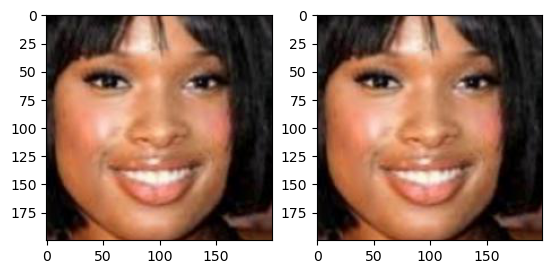

In [4]:
X,_ = next(iter(dl))
im1, im2 = X[4], X[4]
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1.permute(1,2,0))
ax[1].imshow(im2.permute(1,2,0))
dist = nn.PairwiseDistance(p=2.0)(im1.flatten().unsqueeze(0),im2.flatten().unsqueeze(0))
print('distance:', dist)

La diferencia es cero porque se trata de la misma imagen.

distance: tensor([115.6114])


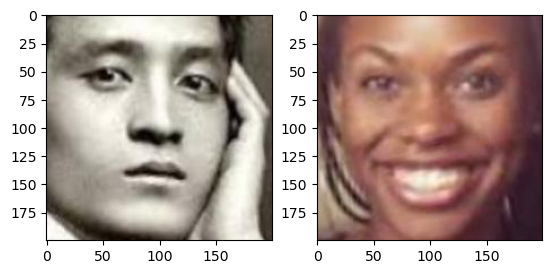

In [6]:
X,_ = next(iter(dl))
im1, im2 = X[0], X[4]
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1.permute(1,2,0))
ax[1].imshow(im2.permute(1,2,0))
dist = nn.PairwiseDistance(p=2.0)(im1.flatten().unsqueeze(0),im2.flatten().unsqueeze(0))
print('distance:', dist)

Aquí la diferencia es más notable porque son imágenes distintas

In [2]:
class Minkowski_Variance:
    def __init__(self, path):
        self.path = path
        data_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.image_dataset = datasets.ImageFolder(path, data_transforms)
        self.class_to_idx = self.image_dataset.class_to_idx
        self.idx_to_class = dict((v,k) for k,v in self.class_to_idx.items())
        print(self.class_to_idx, self.idx_to_class)

        class_0_idxs = torch.nonzero(torch.Tensor(self.image_dataset.targets)==0).flatten()
        class_1_idxs = torch.nonzero(torch.Tensor(self.image_dataset.targets)==1).flatten()

        c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
        b_deg = c0_s / c1_s
        print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

        class_0_subset = Subset(self.image_dataset, class_0_idxs)
        class_1_subset = Subset(self.image_dataset, class_1_idxs)

        self.class_0_dl = torch.utils.data.DataLoader(class_0_subset, batch_size=10, shuffle=True, num_workers=4)
        self.class_1_dl = torch.utils.data.DataLoader(class_1_subset, batch_size=10, shuffle=True, num_workers=4)
        
        print('Calculando distancias clase 0...', end='')
        self.class_0_distances = torch.Tensor([])
        for X, _ in self.class_0_dl:
            distancias = torch.cdist(X.reshape(X.shape[0], -1), X.reshape(X.shape[0], -1))
            sup_t = torch.triu(distancias, diagonal=1)
            sup_t = sup_t[sup_t != 0.]
            self.class_0_distances = torch.cat((self.class_0_distances, sup_t), dim=0)
        print('Done')
        
        print('Calculando distancias clase 1...', end='')
        self.class_1_distances = torch.Tensor([])
        for X, _ in self.class_1_dl:
            distancias = torch.cdist(X.reshape(X.shape[0], -1), X.reshape(X.shape[0], -1))
            sup_t = torch.triu(distancias, diagonal=1)
            sup_t = sup_t[sup_t != 0.]
            self.class_1_distances = torch.cat((self.class_1_distances, sup_t), dim=0)
        print('Done')

    def plot_histograms(self, width=1, num_bins=50, fig_size=(16, 6)):
        """ Muestra los histogramas de distancias de Minkowski de las clases """
        hist = torch.histogram(self.class_0_distances,
                               bins=torch.linspace(
                                   self.class_0_distances.min(),
                                   self.class_0_distances.max(),
                                   num_bins)
                              )
        _, axs = plt.subplots(1,2, figsize=fig_size)
        axs[0].bar(hist.bin_edges[1:], hist.hist.numpy(), align='edge', width=width, color=['forestgreen'])
        axs[0].set_title(f'Varianza intra-clase, Clase {self.idx_to_class[0]}')
        axs[0].set_xlabel('Distancia de Minkowski')
        axs[0].set_ylabel('Frecuencia')

        hist = torch.histogram(self.class_1_distances,
                               bins=torch.linspace(
                                   self.class_1_distances.min(),
                                   self.class_1_distances.max(),
                                   num_bins)
                              )
        axs[1].set_title(f'Varianza intra-clase, Clase {self.idx_to_class[1]}')
        axs[1].bar(hist.bin_edges[1:], hist.hist.numpy(), align='edge', width=width, color=['blue'])
        axs[1].set_xlabel('Distancia de Minkowski')
        axs[1].set_ylabel('Frecuencia')
        plt.show()
        
    def log_statistics(self):
        """ devuelve medidas estadisticas basicas de un tensor 1-D """
        print(f'Estadisticas dataset: {self.path}')
        print('---------------------------------------------------------')
        
        psum = torch.tensor([0.0, 0.0, 0.0])
        psum_sq = torch.tensor([0.0, 0.0, 0.0])
        
        B, C, M,N = next(iter(self.class_0_dl))[0].shape
        for inputs in tqdm(self.class_0_dl):
            imgs, _ = inputs[0], inputs[1]
            psum    += imgs.sum(axis=[0, 2, 3])
            psum_sq += (imgs ** 2).sum(axis=[0, 2, 3])
        pixel_count = len(self.class_0_distances) * M * N
        total_mean = psum / pixel_count
        total_var  = (psum_sq / pixel_count) - (total_mean ** 2)
        total_std  = torch.sqrt(total_var)
        print(f'== Clase {self.idx_to_class[0]}')
        print(f'\tMedia:\t\t\t\t{total_mean.mean()}')  
        print(f'\tDesviacion estándar:\t\t{total_std.mean()}')    
        print(f'\tVarianza:\t\t\t{total_var.mean()}')
        
        for inputs in tqdm(self.class_1_dl):
            imgs, _ = inputs[0], inputs[1]
            psum    += imgs.sum(axis=[0, 2, 3])
            psum_sq += (imgs ** 2).sum(axis=[0, 2, 3])
        pixel_count = len(self.class_1_distances) * M * N
        total_mean = psum / pixel_count
        total_var  = (psum_sq / pixel_count) - (total_mean ** 2)
        total_std  = torch.sqrt(total_var)
        print(f'== Clase {self.idx_to_class[1]}')
        print(f'\tMedia:\t\t\t\t{total_mean.mean()}')  
        print(f'\tDesviacion estándar:\t\t{total_std.mean()}')    
        print(f'\tVarianza:\t\t\t{total_var.mean()}')
        
#         for c, D in enumerate([self.class_0_distances, self.class_1_distances]):
#             mean = torch.mean(D)
#             median = torch.median(D)
#             std = torch.std(D)
#             var = torch.var(D)
            
            
    def plot_PCA(self, s=4):
        print('Computando imagenes...', end='')
        imagenes = np.array([np.array(imagen) for imagen, _ in self.image_dataset])
        print('Done')
        print('Computando etiquetas...', end='')
        etiquetas = np.array([etiqueta for _, etiqueta in self.image_dataset])
        print('Done')
        
        # Aplicamos PCA
        pca = PCA(n_components=2)
        print('Aplicando PCA...', end='')
        pca_resultados = pca.fit_transform(imagenes.reshape(-1, self.image_dataset.__getitem__(0)[0].shape[0]*\
                                                                self.image_dataset.__getitem__(0)[0].shape[1]*\
                                                                self.image_dataset.__getitem__(0)[0].shape[2]))
        print('Done')
        # Creamos un array de colores para cada clase
        colores = ['green' if etiqueta == 0 else 'red' for etiqueta in etiquetas]

        # Creamos la gráfica de PCA
        plt.scatter(pca_resultados[:, 0], pca_resultados[:, 1], c=colores, alpha=0.5, s=s)
        green_patch = mpatches.Patch(color='green', label=self.idx_to_class[0])
        red_patch = mpatches.Patch(color='red', label=self.idx_to_class[1])
        plt.legend(handles=[green_patch, red_patch], loc='upper left')
        plt.title(f'PCA dataset {self.path}')
        plt.show()

## <span style="color:blue">PlantVillage</span>

In [6]:
mv_pv = Minkowski_Variance(path='../data/PlantVillage/train')

{'tomato_healthy': 0, 'tomato_infected': 1} {0: 'tomato_healthy', 1: 'tomato_infected'}
Class 0: 1591 / Class 1: 373 / BDeg:  4.265415549597855
Calculando distancias clase 0...Done
Calculando distancias clase 1...Done


In [7]:
mv_pv.log_statistics()

Estadisticas dataset: ../data/PlantVillage/train
---------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

== Clase tomato_healthy
	Media:				-0.0011170413345098495
	Desviacion estándar:		0.353848934173584
	Varianza:			0.1255229115486145


  0%|          | 0/38 [00:00<?, ?it/s]

== Clase tomato_infected
	Media:				0.007358381990343332
	Desviacion estándar:		0.8018017411231995
	Varianza:			0.6452279686927795


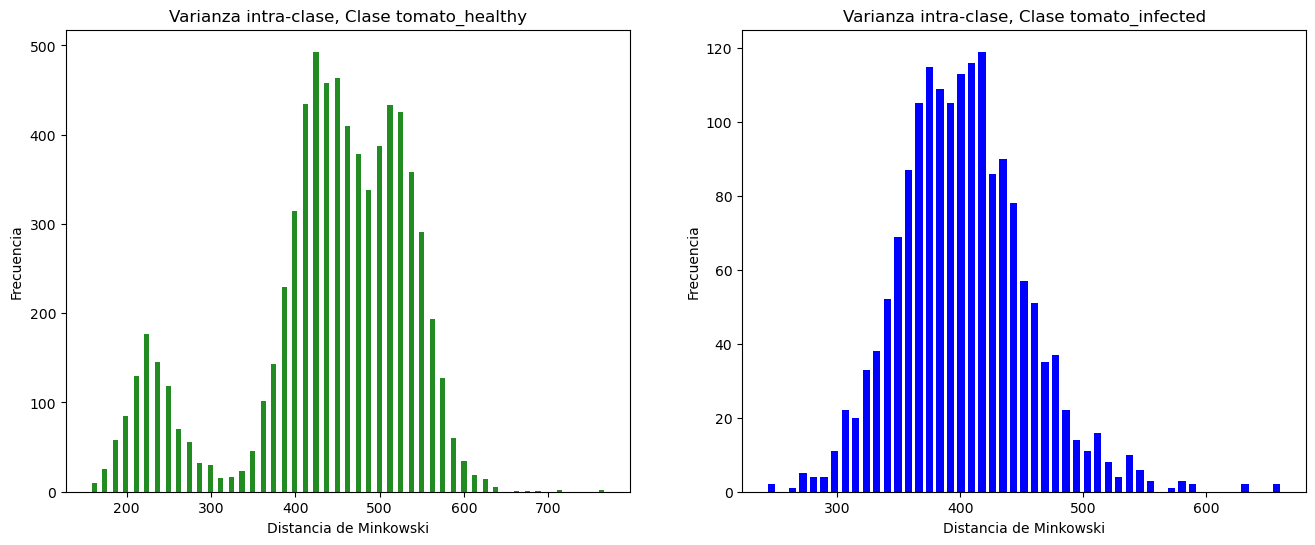

In [8]:
mv_pv.plot_histograms(width=6, num_bins=50, fig_size=(16, 6))

Computando imagenes...Done
Computando etiquetas...Done
Aplicando PCA...Done


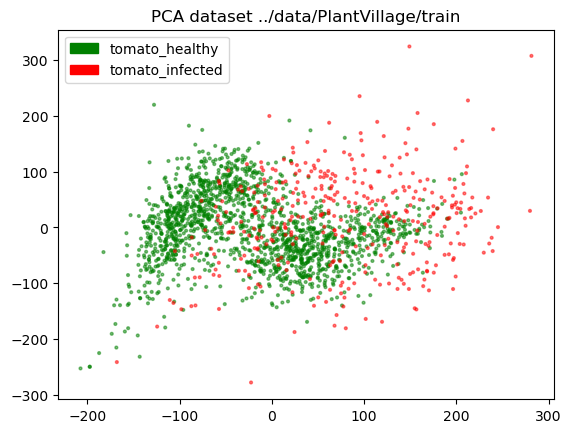

In [13]:
mv_pv.plot_PCA(s=4)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from skimage.feature import graycomatrix
from skimage.feature import greycoprops

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device="cpu"
F_DIMS = 32

# Transformación de imagen para normalización
transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

def get_covariance_matrix(datapath):
    dataset = torchvision.datasets.ImageFolder(root=datapath, transform=transform)

    # Carga una red pre-entrenada
    model = torchvision.models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, F_DIMS, bias=True)
    model.eval()

    # Extre los vectores de características para todas las imágenes en el conjunto de datos
    features = []
    labels = []
    for images, lbls in tqdm(dataset):
        with torch.no_grad():
            images = images.to(device)
            features.append(model(images.unsqueeze(0)).squeeze().numpy())
            labels.append(lbls)

    # Calcule la matriz de covarianza
    return np.cov(np.array(features).T)

def get_h_entropy(datapath):
    # Transformations to apply to the images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])

    # Load the dataset using the ImageFolder class
    dataset = datasets.ImageFolder(root=datapath, transform=transform)

    # Create a DataLoader to iterate over the dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

    # Calculate the entropy of the images
    H = 0
    histo = np.zeros(256)
    for image, label in tqdm(dataloader):
        # Flatten the image tensor
        flat_image = image.view(-1)
        # Calculate the probability distribution of the pixel values
        pixel_probs, BINS = np.histogram(flat_image.numpy(), bins=256, range=(0, 1))
        pixel_probs = pixel_probs/flat_image.shape[0]
        histo += pixel_probs
        # Calculate the entropy of the pixel distribution
        H += -np.sum(pixel_probs * np.log2(pixel_probs + 1e-8))

    # Normalize the entropy by the number of images in the dataset
    H /= len(dataset)
    return H, histo, BINS
#     transform = transforms.Compose([
#         transforms.Resize((256, 256)),
#         transforms.Grayscale(),
#         transforms.ToTensor()
#     ])
#     # Crear el dataloader con batch_size=1
#     dataset = datasets.ImageFolder(root=datapath, transform=transform)
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

#     # Lista para almacenar las entropías
#     entropies = []

#     # Iterar sobre las imágenes del dataloader
#     for images, _ in tqdm(dataloader):
#         # Obtener la imagen actual
#         image = images[0]  # Como batch_size=1, solo hay una imagen en cada batch

#         # Calcular la matriz de frecuencia de los valores de píxel
#         pixel_counts = torch.histc(image, bins=256, min=0, max=255)
#         total_pixels = image.numel()
#         pixel_probs = pixel_counts / total_pixels

#         # Calcular la entropía de Shannon
#         entropy = -torch.sum(pixel_probs * torch.log2(pixel_probs + 1e-7))  # Añadir un pequeño valor para evitar log(0)
#         entropies.append(entropy.item())

#     # Calcular la media y la desviación estándar de las entropías
#     mean_entropy = np.mean(entropies)
#     std_entropy = np.std(entropies)

#     return mean_entropy, std_entropy, entropies

def get_glcm_entropy(datapath):
    # Definir una función para calcular la entropía de una matriz de co-ocurrencia
    def calculate_entropy(glcm):
        normalized_glcm = glcm / float(glcm.sum())
        entropy = -np.sum(normalized_glcm * np.log2(normalized_glcm + 1e-10))
        return entropy.item()

    # Definir la transformación para convertir las imágenes a escala de grises
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])
    # Load the dataset using the ImageFolder class
    dataset = datasets.ImageFolder(root=datapath, transform=transform)

    # Create a DataLoader to iterate over the dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

    # Inicializar una lista para almacenar las entropías
    entropies = []

    # Iterar sobre el dataset y calcular las entropías
    for image, _ in tqdm(dataloader):
        image = image.squeeze(0)
        image *= 255
        image = image.int()
        # Obtener la matriz de co-ocurrencia de niveles de gris
        glcm = graycomatrix(image.squeeze().numpy(), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

        # Calcular la entropía y almacenarla
        entropy = calculate_entropy(glcm)
        entropies.append(entropy)

    # Calcular la media y desviación estándar de las entropías
    entropies_tensor = torch.tensor(entropies)
    mean_entropy = torch.mean(entropies_tensor)
    std_entropy = torch.std(entropies_tensor)
    return mean_entropy, std_entropy, entropies

In [33]:
covariance_matrix_pv = get_covariance_matrix('../data/PlantVillage/train')

  0%|          | 0/1964 [00:00<?, ?it/s]

In [34]:
np.save('./saves/cov_mat_PlantVillage.npy', covariance_matrix_pv)

In [35]:
covariance_matrix_pv = np.load('./saves/cov_mat_PlantVillage.npy')

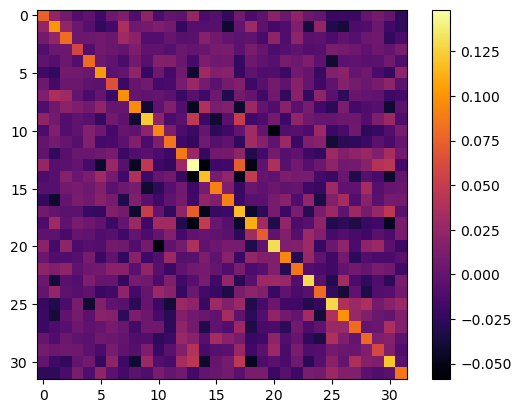

In [36]:
plt.imshow(covariance_matrix_pv, cmap='inferno', interpolation='nearest')
plt.colorbar()
plt.show()

Los valores de la diagonal principal proporcionan una medida de la varianza de cada dimensión de características, mientras que los valores fuera de la diagonal principal miden la covarianza entre las diferentes dimensiones de características.

  0%|          | 0/1964 [00:00<?, ?it/s]

Shannon media-std PlantVillage: 7.09063525202315


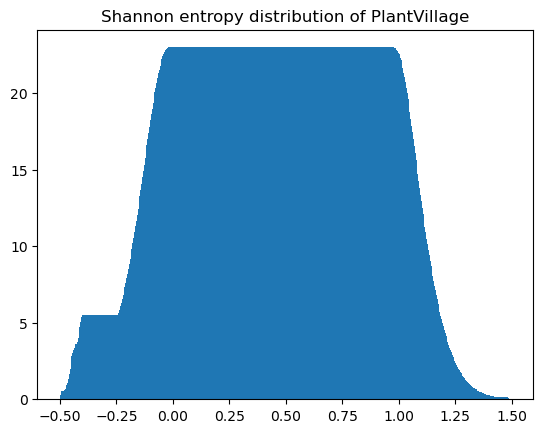

In [9]:
mean_shan_PV, histo_PV, bins_PV = get_h_entropy('../data/PlantVillage/train')
print(f'Shannon media-std PlantVillage: {mean_shan_PV}')
plt.bar(bins_PV[:-1],histo_PV,width=1)
plt.title('Shannon entropy distribution of PlantVillage')
plt.show()

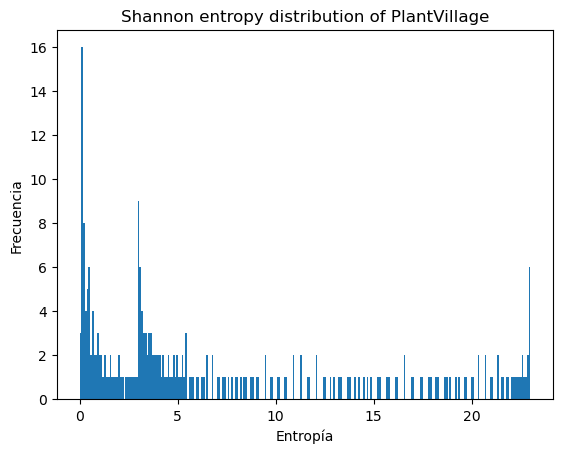

In [29]:
plt.hist(histo_PV, bins=256)
plt.xlabel('Entropía')
plt.ylabel('Frecuencia')
plt.title('Shannon entropy distribution of PlantVillage')
plt.show()

In [23]:
mean_glcm_PV, std_glcm_PV, entropies_glcm_PV = get_glcm_entropy('../data/PlantVillage/train')
print(f'GLCM media-std PlantVillage: {mean_glcm_PV} ({std_glcm_PV})')

  0%|          | 0/1964 [00:00<?, ?it/s]

GLCM media-std PlantVillage: 13.443764686584473 (0.8817151188850403)


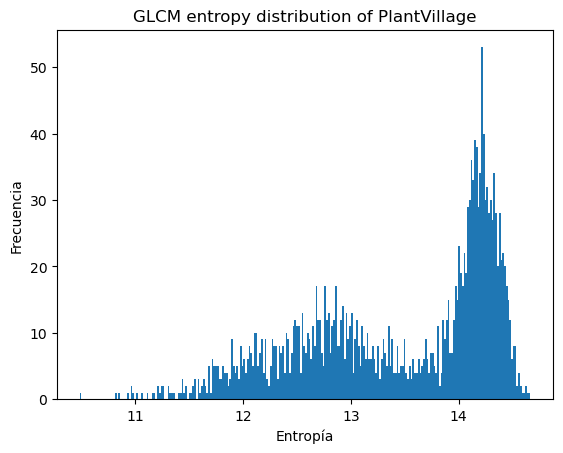

In [24]:
plt.hist(entropies_glcm_PV, bins=256)
plt.xlabel('Entropía')
plt.ylabel('Frecuencia')
plt.title('GLCM entropy distribution of PlantVillage')
plt.show()

In [58]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.cluster import KMeans

# Cargar el dataset de imágenes
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = datasets.ImageFolder("../data/PlantVillage/train", transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

# Definir una CNN pre-entrenada
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, F_DIMS, bias=True)
model.eval()

# Extraer las características de cada imagen
features = []
with torch.no_grad():
    for images, _ in tqdm(loader):
        outputs = model(images)
        features.append(outputs.cpu().numpy())
features = np.concatenate(features)

# Normalizar las características
features = torch.from_numpy(features)
features = torch.nn.functional.normalize(features, dim=1)

  0%|          | 0/62 [00:00<?, ?it/s]

In [60]:
# Aplicar K-means al conjunto de características
kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(features)
labels

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


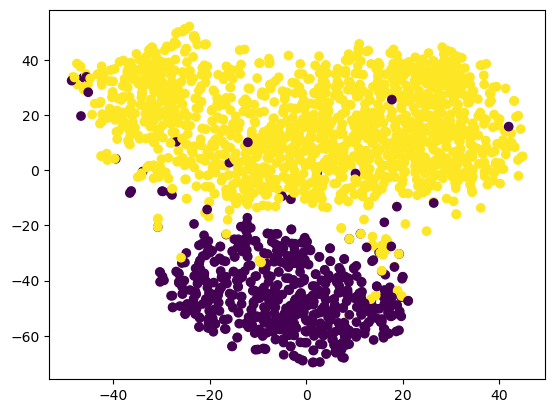

In [62]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(features)

# Graficamos los puntos con diferentes colores según su cluster asignado
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.show()

## <span style="color:blue">UTKFace</span>

In [15]:
mv_utk = Minkowski_Variance(path='../data/UTKFace/train')

{'female': 0, 'male': 1} {0: 'female', 1: 'male'}
Class 0: 8987 / Class 1: 9883 / BDeg:  0.9093392694525954
Calculando distancias clase 0...Done
Calculando distancias clase 1...Done


In [16]:
mv_utk.log_statistics()

Estadisticas dataset: ../data/UTKFace/train
---------------------------------------------------------


  0%|          | 0/899 [00:00<?, ?it/s]

== Clase female
	Media:				0.030070925131440163
	Desviacion estándar:		0.5260886549949646
	Varianza:			0.27904820442199707


  0%|          | 0/989 [00:00<?, ?it/s]

== Clase male
	Media:				0.058573637157678604
	Desviacion estándar:		0.7022866606712341
	Varianza:			0.49592265486717224


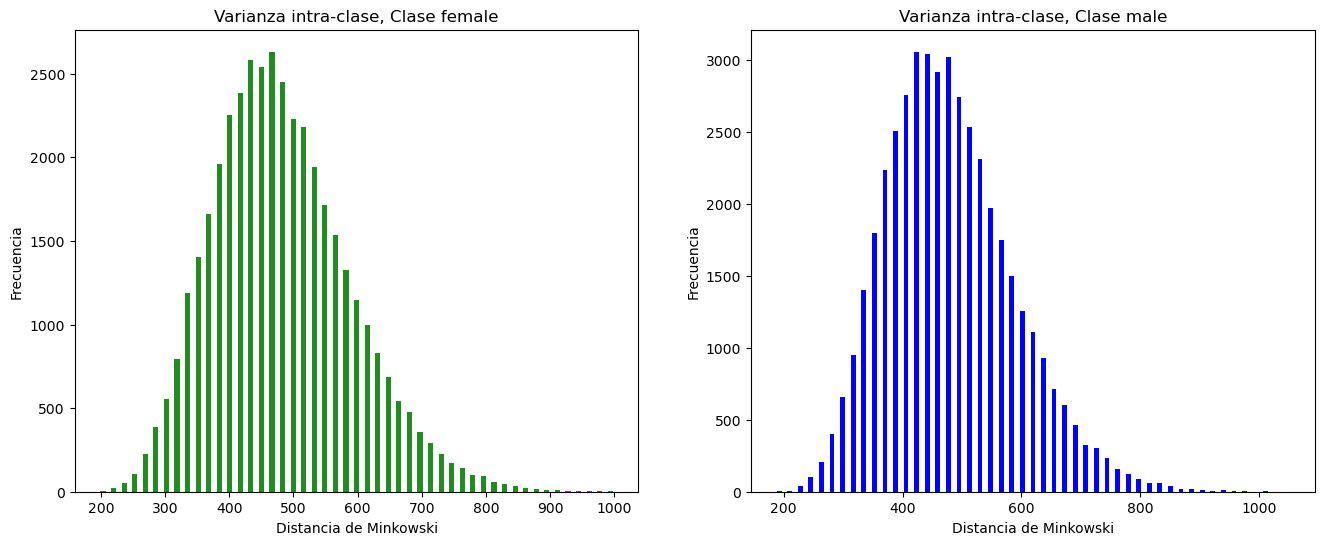

In [17]:
mv_utk.plot_histograms(width=8)

In [ ]:
mv_utk.plot_PCA(s=4)

Computando imagenes...

In [23]:
covariance_matrix_utk = get_covariance_matrix('../data/UTKFace/train')

  0%|          | 0/15802 [00:00<?, ?it/s]

In [25]:
np.save('./saves/cov_mat_UTKFace.npy', covariance_matrix_utk)

In [37]:
covariance_matrix_utk = np.load('./saves/cov_mat_UTKFace.npy')

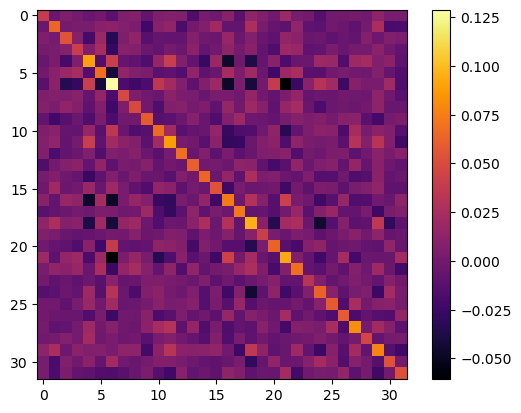

In [38]:
plt.imshow(covariance_matrix_utk, cmap='inferno', interpolation='nearest')
plt.colorbar()
plt.show()

In [17]:
h_UTKFace, histo_UTK, bins_UTK = get_h_entropy('../data/UTKFace/train')
print('Shannon Entropy of UTKFace: ', h_UTKFace)

  0%|          | 0/23708 [00:00<?, ?it/s]

Shannon Entropy of UTKFace:  7.262702219927676


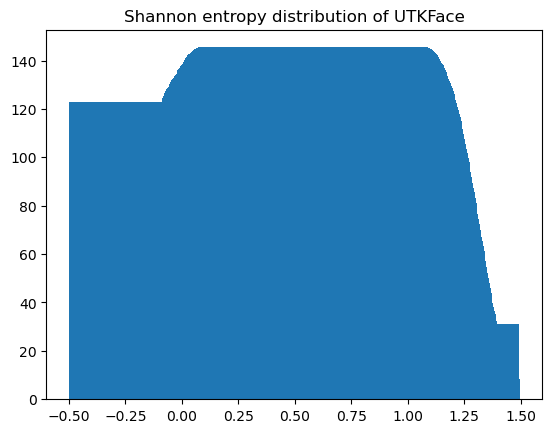

In [18]:
plt.bar(bins_UTK[:-1],histo_UTK,width=1)
plt.title('Shannon entropy distribution of UTKFace')
plt.show()

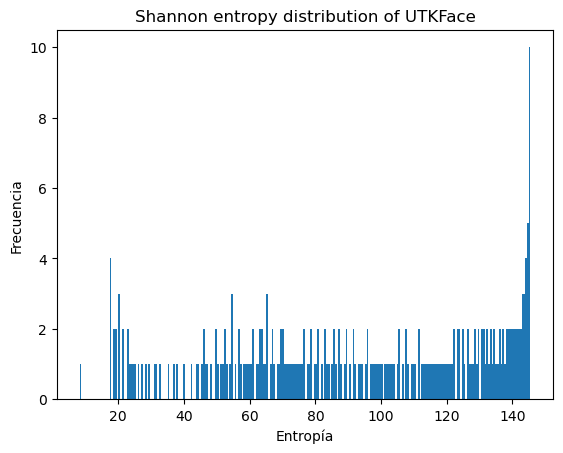

In [28]:
plt.hist(histo_UTK, bins=256)
plt.xlabel('Entropía')
plt.ylabel('Frecuencia')
plt.title('Shannon entropy distribution of UTKFace')
plt.show()

In [25]:
mean_glcm_UTK, std_glcm_UTK, entropies_glcm_UTK = get_glcm_entropy('../data/UTKFace/train')
print(f'GLCM media-std UTKFace: {mean_glcm_UTK} ({std_glcm_UTK})')

  0%|          | 0/23708 [00:00<?, ?it/s]

GLCM media-std UTKFace: 10.745245933532715 (0.6235407590866089)


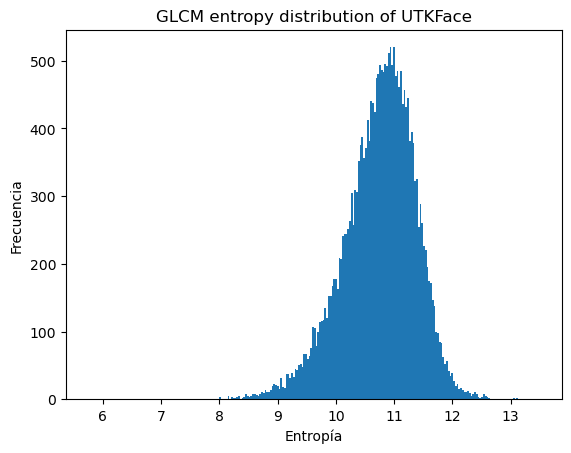

In [30]:
plt.hist(entropies_glcm_UTK, bins=256)
plt.xlabel('Entropía')
plt.ylabel('Frecuencia')
plt.title('GLCM entropy distribution of UTKFace')
plt.show()

In [63]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.cluster import KMeans

# Cargar el dataset de imágenes
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = datasets.ImageFolder("../data/UTKFace/train", transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

# Definir una CNN pre-entrenada
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, F_DIMS, bias=True)
model.eval()

# Extraer las características de cada imagen
features = []
with torch.no_grad():
    for images, _ in tqdm(loader):
        outputs = model(images)
        features.append(outputs.cpu().numpy())
features = np.concatenate(features)

# Normalizar las características
features = torch.from_numpy(features)
features = torch.nn.functional.normalize(features, dim=1)

  0%|          | 0/494 [00:00<?, ?it/s]

In [64]:
# Aplicar K-means al conjunto de características
kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(features)
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(features)

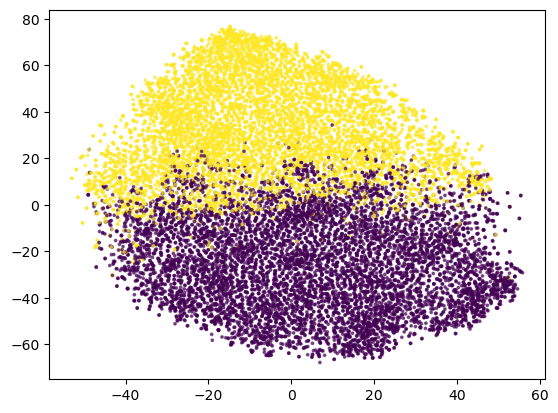

In [68]:
# Graficamos los puntos con diferentes colores según su cluster asignado
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, alpha=0.6, s=3)
plt.show()

## <span style="color:blue">Fair Face</span>

In [ ]:
mv_ff = Minkowski_Variance(path='../data/FairFace/train')

In [ ]:
mv_ff.log_statistics()

In [ ]:
mv_ff.plot_histograms(width=10)

In [ ]:
mv_ff.plot_PCA(s=4)

## <span style="color:blue">MNIST (sólo 0 y 1)</span>

In [16]:
mv_mnist = Minkowski_Variance(path='../data/MNIST')

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9} {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
Class 0: 6796 / Class 1: 7740 / BDeg:  0.8780361757105943
Calculando distancias clase 0...Done
Calculando distancias clase 1...Done


In [17]:
mv_mnist.log_statistics()

Estadisticas dataset: ../data/MNIST
---------------------------------------------------------


  0%|          | 0/680 [00:00<?, ?it/s]

== Clase 0
	Media:				-0.26716506481170654
	Desviacion estándar:		0.872940719127655
	Varianza:			0.7628682255744934


  0%|          | 0/774 [00:00<?, ?it/s]

== Clase 1
	Media:				-0.5981218814849854
	Desviacion estándar:		1.106249451637268
	Varianza:			1.2252979278564453


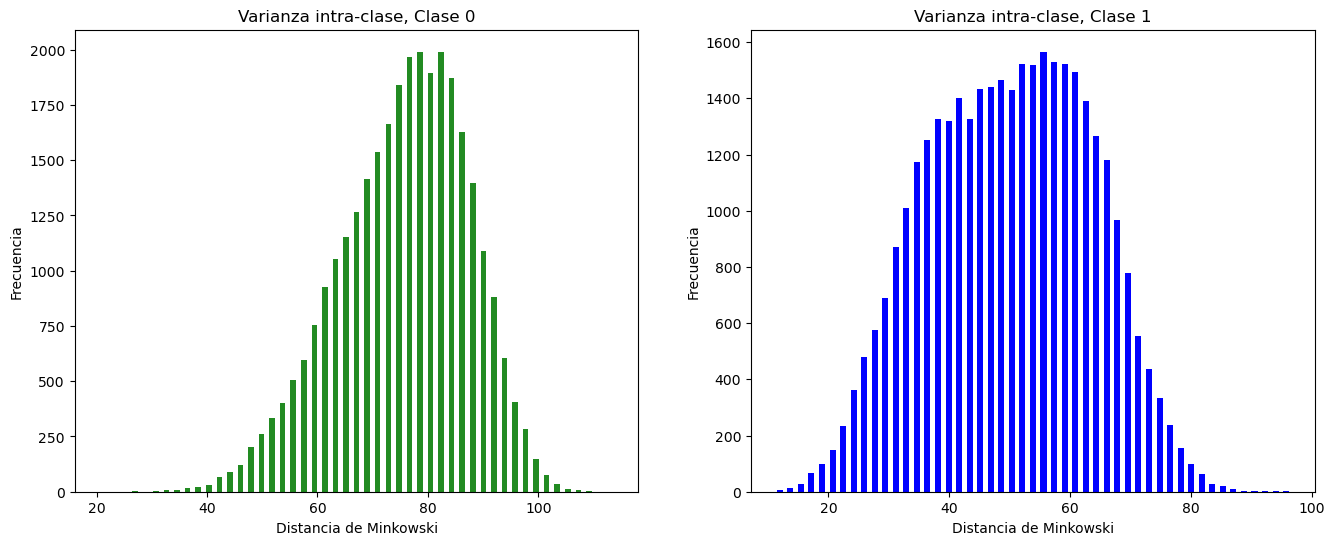

In [18]:
mv_mnist.plot_histograms(width=1)

In [ ]:
mv_mnist.plot_PCA(s=4)

In [40]:
covariance_matrix_mnist = get_covariance_matrix('../data/MNIST/')

  0%|          | 0/13701 [00:00<?, ?it/s]

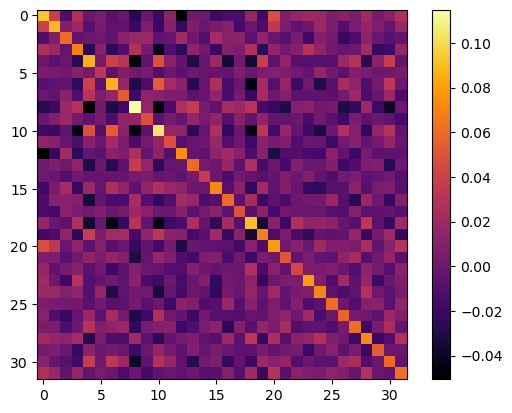

In [41]:
plt.imshow(covariance_matrix_mnist, cmap='inferno', interpolation='nearest')
plt.colorbar()
plt.show()

In [31]:
h_MNIST, histo_MNIST, bins_MNIST = get_h_entropy('../data/MNIST/')
print('Shannon Entropy of MNIST: ', h_MNIST)

  0%|          | 0/13701 [00:00<?, ?it/s]

Shannon Entropy of MNIST:  4.5881146209847685


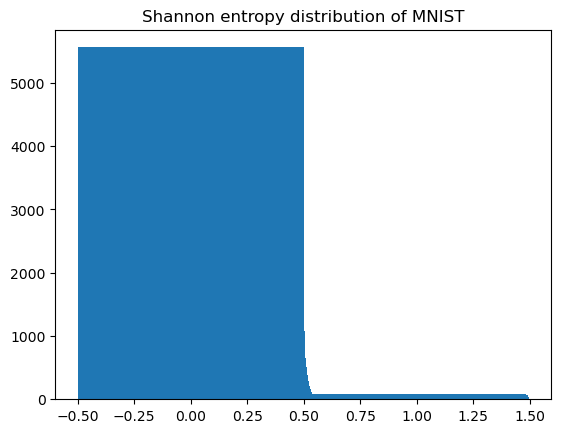

In [32]:
plt.bar(bins_MNIST[:-1],histo_MNIST,width=1)
plt.title('Shannon entropy distribution of MNIST')
plt.show()

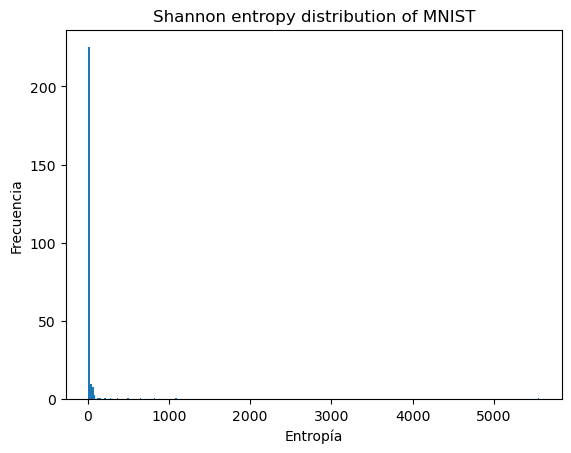

In [33]:
plt.hist(histo_MNIST, bins=256)
plt.xlabel('Entropía')
plt.ylabel('Frecuencia')
plt.title('Shannon entropy distribution of MNIST')
plt.show()

In [34]:
mean_glcm_MNIST, std_glcm_MNIST, entropies_glcm_MNIST = get_glcm_entropy('../data/MNIST/')
print(f'GLCM media-std MNIST: {mean_glcm_MNIST} ({std_glcm_MNIST})')

  0%|          | 0/13701 [00:00<?, ?it/s]

GLCM media-std MNIST: 6.445398807525635 (0.6048272848129272)


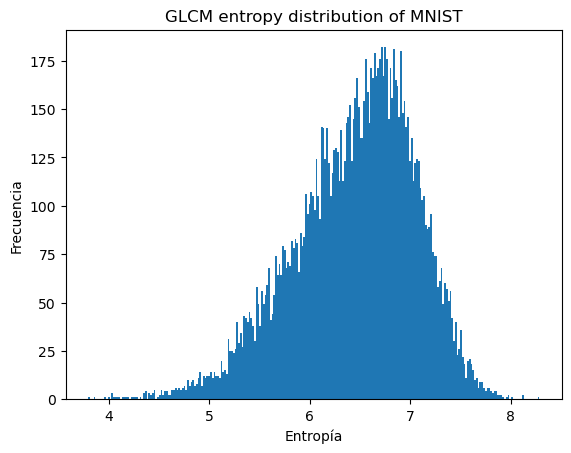

In [35]:
plt.hist(entropies_glcm_MNIST, bins=256)
plt.xlabel('Entropía')
plt.ylabel('Frecuencia')
plt.title('GLCM entropy distribution of MNIST')
plt.show()

# PCA

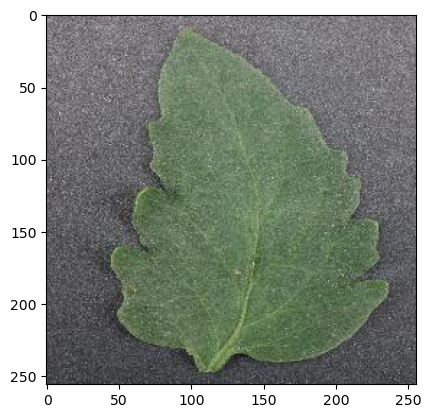

In [3]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.autonotebook import tqdm

faces = np.zeros((256*256*3))
targets = np.array([])
for path in tqdm(glob.glob('../data/PlantVillage/train/*/*.JPG')):
    img = np.array(Image.open(path))
    plt.imshow(img.transpose(0,1,2))
    faces = np.vstack((faces, img.flatten()))
    if 'tomato_healthy' in path: targets = np.append(targets, 0)
    elif 'tomato_infected' in path: targets = np.append(targets, 1)

In [ ]:
#Import required modules
from sklearn.decomposition import PCA
 
pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(faces)

faces.shape, targets.shape, converted_data.shape

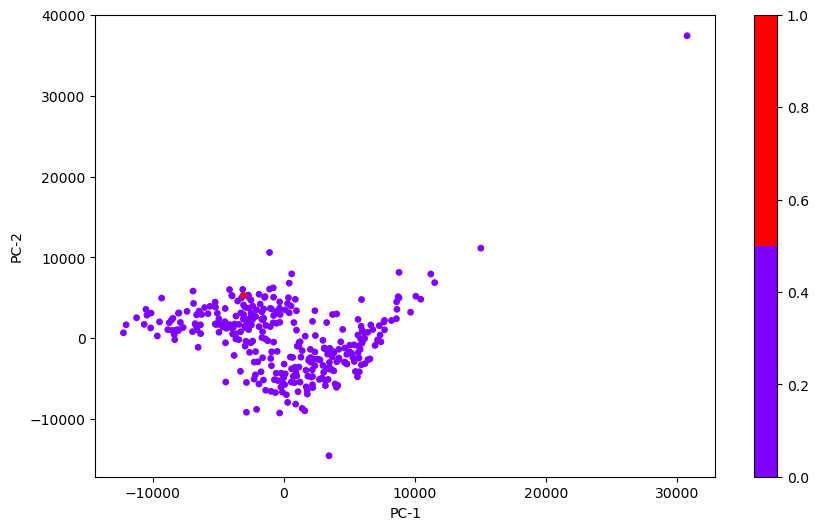

In [11]:
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('rainbow', 2)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15,
            cmap = c_map , c = targets)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

# UMAP

## <span style="color:blue">digits (example)</span>

In [2]:
import umap
import umap.plot
from sklearn.datasets import load_digits

digits = load_digits()

mapper = umap.UMAP().fit(digits.data)
umap.plot.points(mapper, labels=digits.target)

AttributeError: module 'tensorflow' has no attribute '__version__'

In [ ]:
digits.data.shape, digits.target.shape

In [ ]:
data_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])
image_dataset = datasets.ImageFolder('../data/PlantVillage/train', data_transforms)
pv_dl = torch.utils.data.DataLoader(image_dataset, batch_size=10, shuffle=True, num_workers=4)
data = np.zeros((1*256*256))
target = np.array([])
for imgs, labels in tqdm(pv_dl):
    data=np.vstack((data, imgs.numpy().reshape(imgs.shape[0], imgs.shape[1]*imgs.shape[2]*imgs.shape[3])))
    target = np.append(target, labels)
data = data[1:]
data.shape, target.shape

## <span style="color:blue">PlantVillage</span>

<AxesSubplot:>

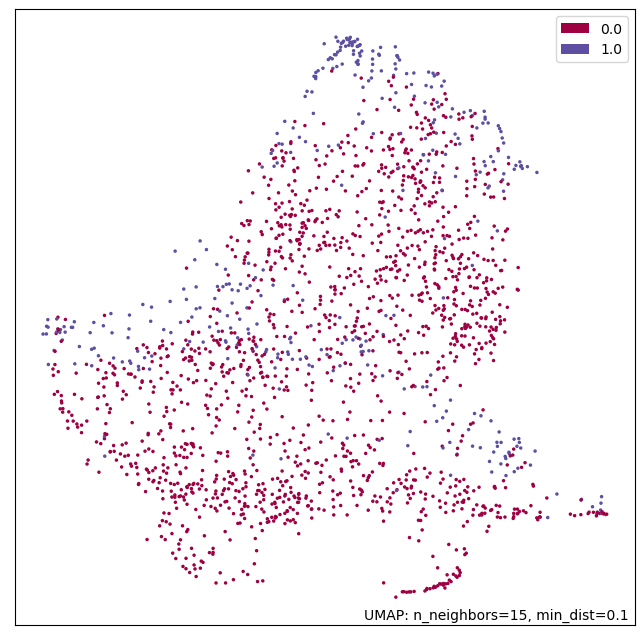

In [7]:
mapper = umap.UMAP().fit(data)
umap.plot.points(mapper, labels=target)